In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [6]:
data = pd.read_excel("owid-covid-data.xlsx")
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


In [10]:

netherlands = data[data['location'] == "Netherlands"]
netherlands = netherlands[['date', 'new_cases']]
netherlands.set_index('date', inplace=True)
netherlands.index = pd.to_datetime(netherlands.index)

netherlands.head(10)

NameError: name 'netherlands_data' is not defined

In [11]:
netherlands.shape


(1357, 1)

In [12]:
# ARIMA is senstive to missing values
# count and indices of missing values
missing_count = netherlands['new_cases'].isna().sum()
print(f"Count of missing values: {missing_count}")

missing_indices = netherlands[netherlands['new_cases'].isna()].index.tolist()
print(f"Indices of missing values: {missing_indices}")

Count of missing values: 0
Indices of missing values: []


In [20]:
# drop the last values as it may bias test performance
dates_to_drop = ['2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20']
netherlands = netherlands.drop(pd.to_datetime(dates_to_drop))
netherlands.tail()

KeyError: "[Timestamp('2023-09-15 00:00:00'), Timestamp('2023-09-16 00:00:00'), Timestamp('2023-09-17 00:00:00'), Timestamp('2023-09-18 00:00:00'), Timestamp('2023-09-19 00:00:00'), Timestamp('2023-09-20 00:00:00')] not found in axis"

In [21]:
# test train split 
train=netherlands.iloc[:-200 ]['new_cases']
test=netherlands.iloc[-200: ]['new_cases']
train = train.to_frame('new_cases')
test = test.to_frame('new_cases')
print(train.shape, test.shape)

(1157, 1) (200, 1)


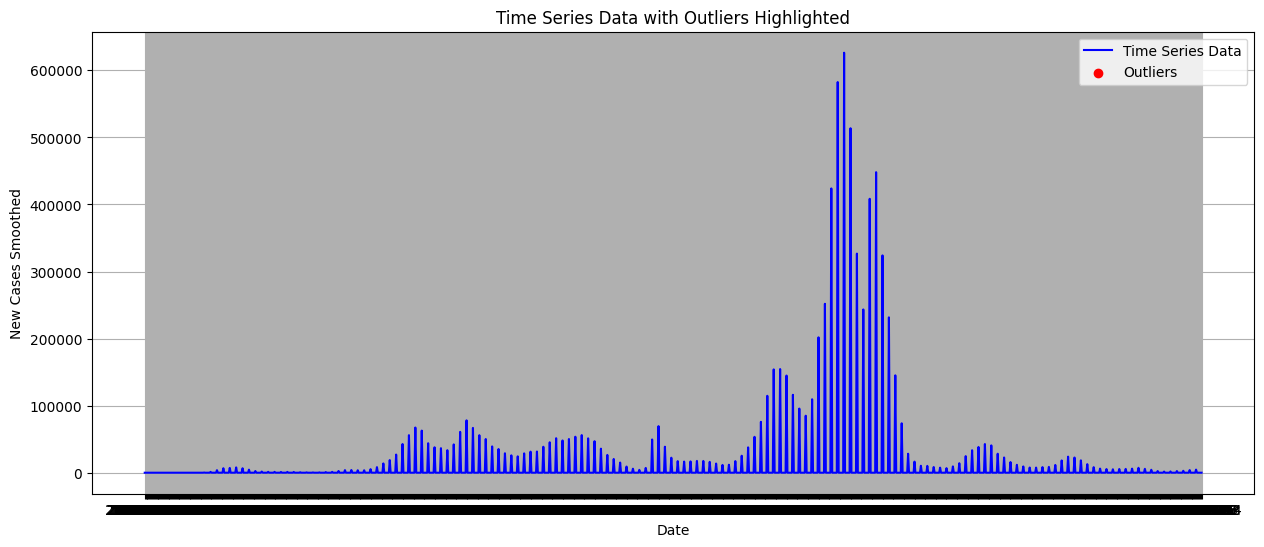

In [22]:
# ARIMA is sentive to outliers
Q1 = train['new_cases'].quantile(0.25)
Q3 = train['new_cases'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = train[(train['new_cases'] < lower_bound) | (train['new_cases'] > upper_bound)]

plt.figure(figsize=(15, 6))
plt.plot(train.index, train['new_cases'], label='Time Series Data', color='blue')
plt.scatter(outliers.index, outliers['new_cases'], color='red', label='Outliers')
plt.title('Time Series Data with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('New Cases Smoothed')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# cap the outliers at 100,000 to minimize impact of peaks
train['new_cases'] = train['new_cases'].apply(lambda x: 100000 if x > 100000 else x)
train.describe()

,new_cases
count,1157.000000
mean,4299.357822
std,16135.854814
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,100000.000000


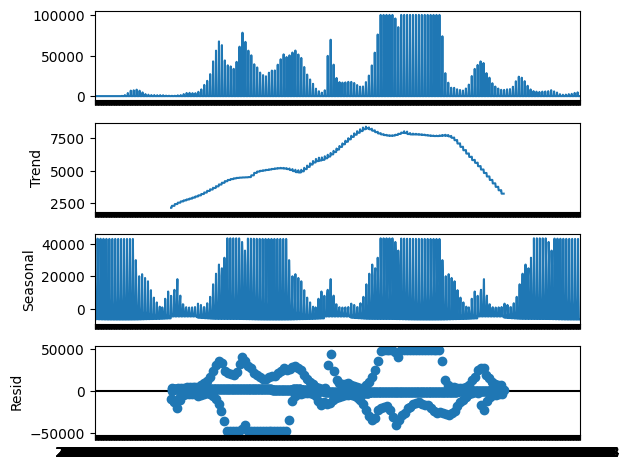

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(train, period=365).plot()
plt.show()

In [25]:
# test for stationarity
from statsmodels.tsa.stattools import adfuller

X = train.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))
 #The time series is not stationary at the 5% significance level.
 #This means that the time series doesn't exhibit trends or seasonality. 
 # I will start with d = 0 in the model.



ADF Statistic: -2.332745
p-value: 0.161624
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


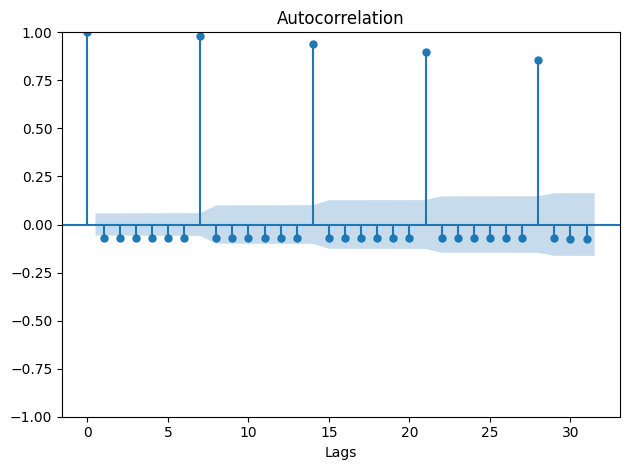

In [26]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
alpha=0.05
# Select a multiple of the seasonal frequency for the number of lags
plot_acf(train['new_cases'])
plt.xlabel('Lags')
plt.tight_layout()

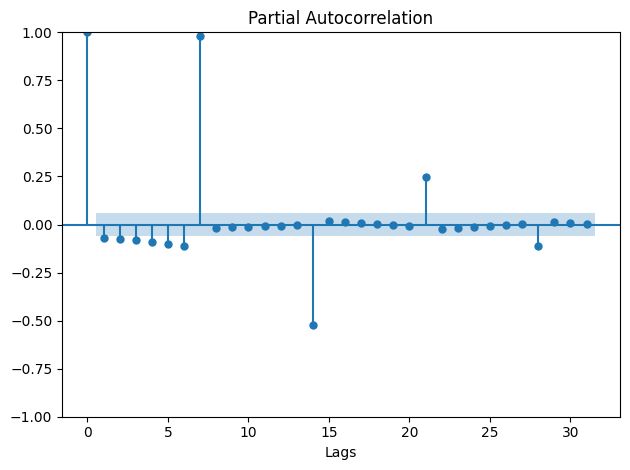

In [27]:
plot_pacf(train['new_cases'])
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

In [30]:

model = ARIMA(train, order=(4, 0, 2))
model=model.fit()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

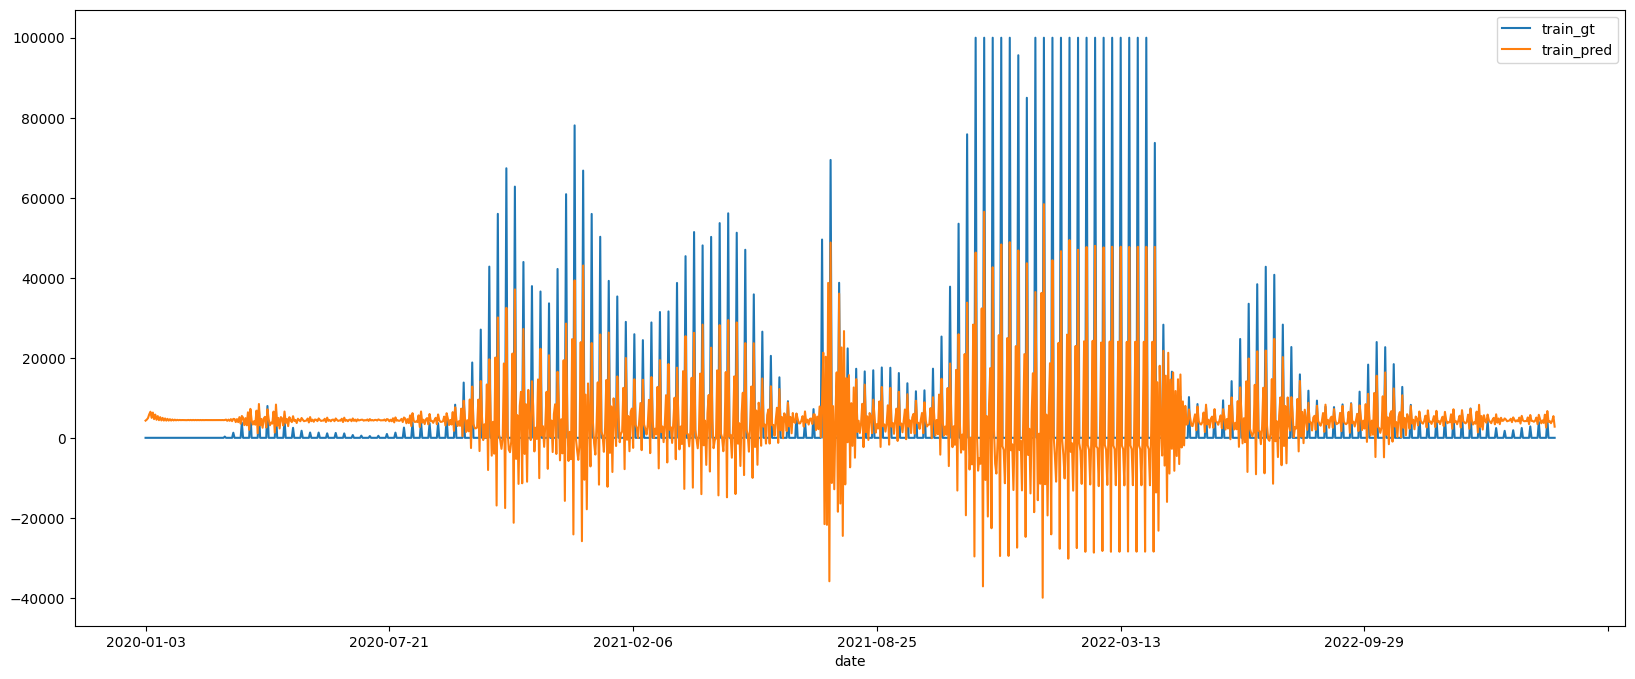

In [31]:
train_pred=model.fittedvalues
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

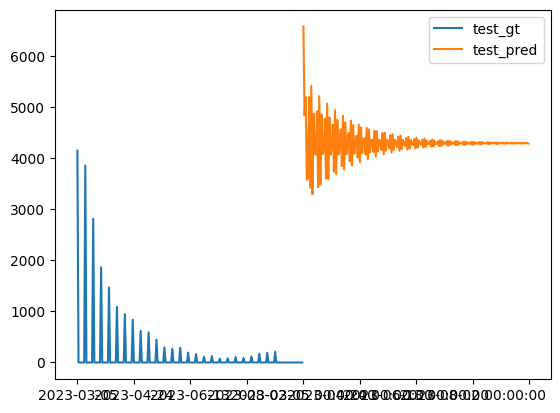

In [32]:
test_pred=model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])


In [33]:
train_rmse = np.sqrt(mean_squared_error(train, train_pred))
test_rmse = np.sqrt(mean_squared_error(test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 11721.479158790788
Test RMSE: 4224.660605065627


In [35]:
model2 = ARIMA(train, order=(2, 1, 0))
model2=model2.fit()



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


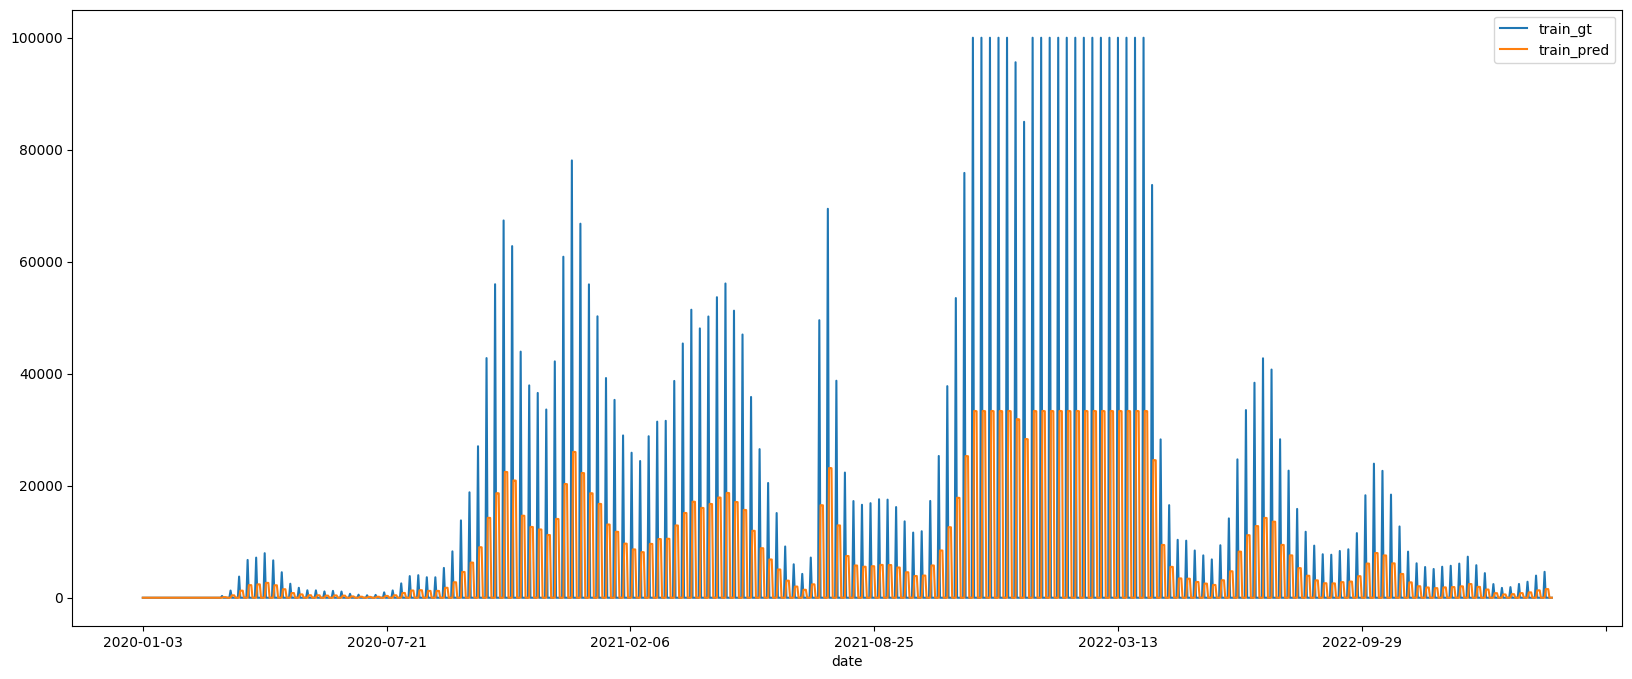

In [36]:
train_pred=model2.fittedvalues
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

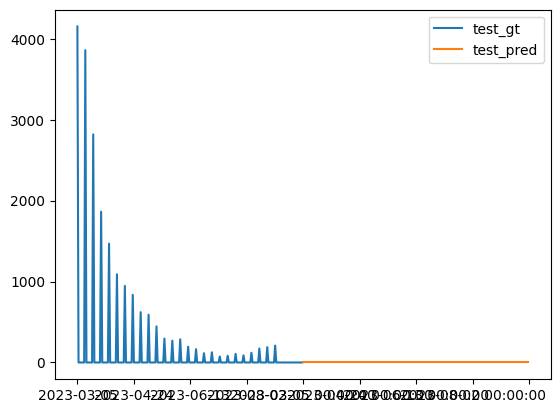

In [37]:
test_pred=model2.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

In [38]:
train_rmse = np.sqrt(mean_squared_error(train, train_pred))
test_rmse = np.sqrt(mean_squared_error(test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 19274.344951359097
Test RMSE: 499.6628913577633


In [39]:
# AUTO Arima
from pmdarima.arima import auto_arima
model_auto = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(model_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=21.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=27092.927, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=26615.490, Time=1.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=8.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=27012.209, Time=0.27 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=26517.208, Time=3.88 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=7.21 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=26764.422, Time=1.89 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=26314.674, Time=5.85 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=26488.462, Time=1.94 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.23 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.24 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=inf, Time=7.02 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=258

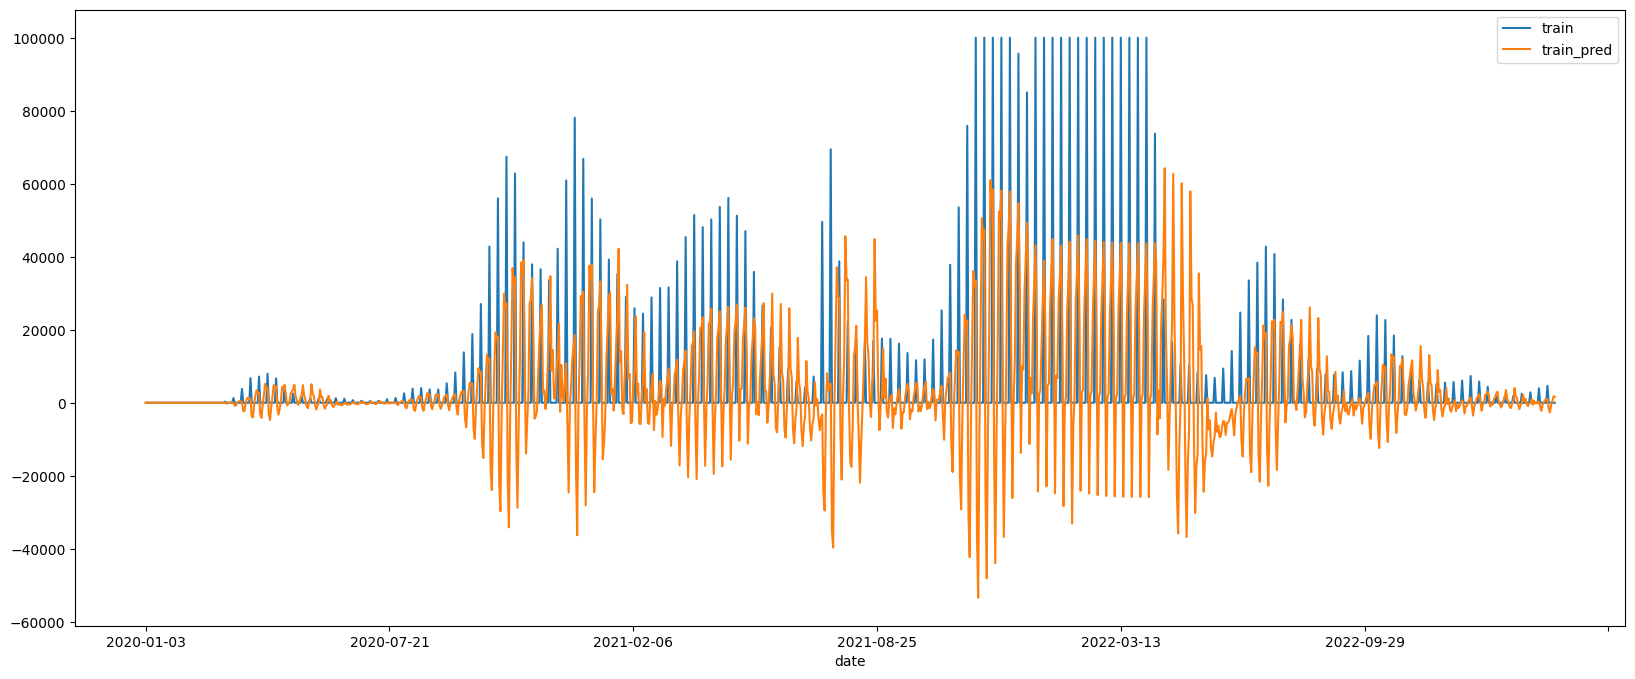

In [40]:
train_pred=model_auto.fittedvalues()
pd.concat([train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])

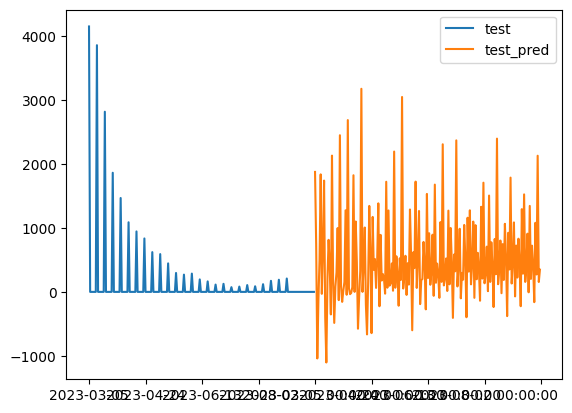

In [41]:
test_pred=model_auto.predict(n_periods=len(test))
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])


In [42]:
train_rmse = np.sqrt(mean_squared_error(train, train_pred))
test_rmse = np.sqrt(mean_squared_error(test, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 16479.620913426887
Test RMSE: 948.2239714173588
